# Case Study 3

#### Predicting Central Neuropathic Pain (CNP) in people with Spinal Cord Injury (SCI) from Electroencephalogram (EEG) data.

* CNP is pain in response to non-painful stimuli, episodic (electric shock), “pins and needles”, numbness
* There is currently no treatment, only prevention
* Preventative medications have strong side-effects
* Predicting whether a patient is likely to develop pain is useful for selective treatment

#### Task
Your task is to devise a feature engineering strategy which, in combination with a classifier of your choice, optizimes prediction accuracy.

#### Data
The data is preprocessed brain EEG data from SCI patients recorded while resting with eyes closed (EC) and eyes opened (EO).
* 48 electrodes recording electrical activity of the brain at 250 Hz 
* 2 classes: subject will / will not develop neuropathic pain within 6 months
* 18 subjects: 10 developed pain and 8 didn’t develop pain
* the data has already undergone some preprocessing
  * Signal denoising and normalization
  * Temporal segmentation
  * Frequency band power estimation
  * Normalization with respect to total band power
  * Features include normalized alpha, beta, theta band power while eyes closed, eyes opened, and taking the ratio of eo/ec.
* the data is provided in a single table ('data.csv') consisting of 
  * 180 rows (18 subjects x 10 repetitions), each containing
  * 432 columns (9 features x 48 electrodes)
  * rows are in subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
  * columns are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
  * feature identifiers for all columns are stored in 'feature_names.csv'
  * 'labels.csv' defines the corresponding class (0 or 1) to each row in data.csv

#### Objective Measure
Leave one subject out cross-validation accuracy, sensitivity and specificity.

#### Report
Report on your feature engineering pipeline, the classifier used to evaluate performance, and the performance as mean and standard deviation of accuracy, sensitivity and specificity across folds. Give evidence for why your strategy is better than others.

#### Requirements

  * compare at least 2 feature selection methods (groups of 5-6: at least 4)
    - filtering methods (at least one scoring function)
    - wrapper methods (at least one, e.g., forward feature selection or backward feature elimination)
    - embedding methods  (at least one, e.g., L1 regularisation)
 * combine each method with at least 2 classifiers 
   (justify your choice of classifiers in the report)
    - SVM
    - KNN
    - RandomForest, DecisionTree etc
  * perform Leave-one-group-out cross-validation, where all 10 samples from each subject are in one group (18 groups in total)
  * use cross-validation to optimise hyper-parameter values
  * as a baseline for comparison, evaluate each of your classifiers trained on the full set of features (trained without feature selection)




## Understanding the Data

### Data Characteristics

In [1]:
import csv
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_selection import SelectKBest,chi2, f_classif, mutual_info_classif
from sklearn.model_selection import cross_val_score , train_test_split, LeaveOneGroupOut, cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import KBinsDiscretizer
from scipy.stats import pearsonr
import json
import matplotlib.pyplot as plt


In [2]:
# load data
# rows in X are subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
# columns in X are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
# feature identifiers for all columns in X are stored in feature_names.csv

X = np.loadtxt('csv/data.csv', delimiter=',') 
y = np.loadtxt('csv/labels.csv', delimiter=',')
with open('csv/feature_names.csv') as f:
    csvreader = csv.reader(f, delimiter=',')
    feature_names = [row for row in csvreader][0]

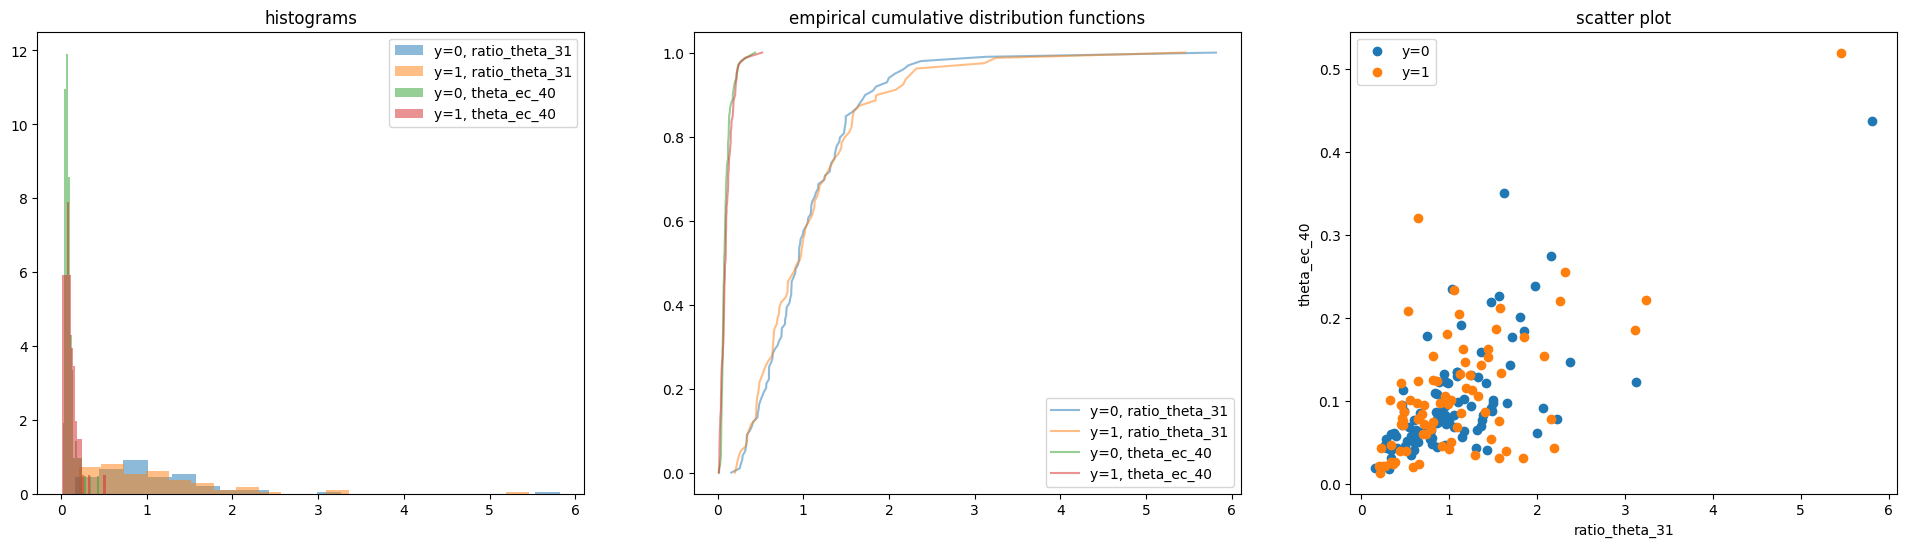

In [25]:
# plotting data in 2D with axes sampled 
# a) at random 
# b) from same electrode
# c) from same feature type
num_features = 9
num_electrodes = 48

# a) indices drawn at random
i0, i1 = np.random.randint(0, X.shape[1], size=2)

# b) same electrode, different feature (uncomment lines below)
#f0, f1 = np.random.randint(0, num_features, size=2)
#e = np.random.randint(0, num_electrodes)
#i0, i1 = f0*num_electrodes + e, f1*num_electrodes + e

# b) same feature, different electrode (uncomment lines below)
#f = np.random.randint(0, num_features)
#e0, e1 = np.random.randint(0, num_electrodes, size=2)
#i0, i1 = f*num_electrodes + e0, f*num_electrodes + e1

fig, axes = plt.subplots(1, 3, figsize=(24, 6))
colors = ['blue', 'red']

# select features i0, i1 and separate by class
X00, X01 = X[y==0][:,i0], X[y==1][:,i0]
X10, X11 = X[y==0][:,i1], X[y==1][:,i1]
# plot cumulative distribution of feature i0 separate for each class
axes[0].hist(X00, bins=20, label='y=0, '+ feature_names[i0], density=True, alpha=0.5)
axes[0].hist(X01, bins=20, label='y=1, '+ feature_names[i0], density=True, alpha=0.5)
axes[0].hist(X10, bins=20, label='y=0, '+ feature_names[i1], density=True, alpha=0.5)
axes[0].hist(X11, bins=20, label='y=1, '+ feature_names[i1], density=True, alpha=0.5)
axes[0].set_title('histograms')
axes[0].legend()
axes[1].plot(np.sort(X00), np.linspace(0,1,X00.shape[0]), label='y=0, '+ feature_names[i0], alpha=0.5)
axes[1].plot(np.sort(X01), np.linspace(0,1,X01.shape[0]), label='y=1, '+ feature_names[i0], alpha=0.5)
axes[1].plot(np.sort(X10), np.linspace(0,1,X10.shape[0]), label='y=0, '+ feature_names[i1], alpha=0.5)
axes[1].plot(np.sort(X11), np.linspace(0,1,X11.shape[0]), label='y=1, '+ feature_names[i1], alpha=0.5)
axes[1].set_title('empirical cumulative distribution functions')
axes[1].legend()
axes[2].scatter(X00, X10, label='y=0')
axes[2].scatter(X01, X11, label='y=1')
axes[2].set_xlabel(feature_names[i0])
axes[2].set_ylabel(feature_names[i1])
axes[2].set_title('scatter plot')
axes[2].legend()

In [3]:
#Load data in from csv files and convert to pandas dataframes
# File paths
data_file = 'csv/data.csv'
labels_file = 'csv/labels.csv'
feature_names_file = 'csv/feature_names.csv'

# Reload the datasets
feature_names = pd.read_csv(feature_names_file)
f = feature_names.columns.tolist()
data = pd.read_csv(data_file, header=None, names=f)
X = data
labels = pd.read_csv(labels_file, header=None)
y = labels

In [4]:
data

,alpha_ec_0,alpha_ec_1,alpha_ec_2,alpha_ec_3,alpha_ec_4,alpha_ec_5,alpha_ec_6,alpha_ec_7,alpha_ec_8,alpha_ec_9,...,ratio_theta_38,ratio_theta_39,ratio_theta_40,ratio_theta_41,ratio_theta_42,ratio_theta_43,ratio_theta_44,ratio_theta_45,ratio_theta_46,ratio_theta_47
0,0.111840,0.123870,0.128580,0.113240,0.105710,0.106900,0.107560,0.110640,0.108750,0.158930,...,0.57161,0.73870,0.58709,0.55198,0.54811,0.57869,0.59345,0.60436,0.56294,1.01440
1,0.298340,0.268810,0.262390,0.380090,0.343580,0.285000,0.247910,0.250330,0.260470,0.260160,...,0.35142,0.32788,0.43164,0.49603,0.40680,0.31283,0.66352,0.58386,0.46658,0.74867
2,0.369120,0.395870,0.389990,0.257720,0.405540,0.441990,0.440040,0.399470,0.315460,0.283480,...,0.61924,0.86506,1.09310,0.31759,0.36353,0.50553,0.33478,0.49383,0.62363,0.61417
3,0.761200,0.777260,0.770420,0.601610,0.701830,0.727250,0.762450,0.789040,0.729840,0.522360,...,0.23456,0.25090,0.43196,0.71301,0.53340,0.28528,0.68135,0.66315,0.25250,0.85448
4,0.167700,0.151460,0.147140,0.157280,0.149650,0.141540,0.132280,0.127600,0.143510,0.172520,...,1.82160,1.73190,1.24420,2.76220,3.00930,2.43520,2.53070,2.58470,2.00770,2.29460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.079822,0.081258,0.079273,0.083723,0.069784,0.063498,0.061792,0.059784,0.066457,0.077352,...,1.31050,1.16220,0.95190,2.32520,1.87490,1.74620,2.72400,2.71860,2.82880,1.23630
176,0.346500,0.362790,0.343660,0.277240,0.316030,0.379750,0.420140,0.452390,0.421380,0.250020,...,0.69648,0.67680,0.82459,0.37865,0.45749,0.61751,0.35155,0.48109,0.65537,0.64262
177,0.159210,0.157820,0.169680,0.178980,0.140980,0.132490,0.126600,0.130490,0.149720,0.222240,...,1.04600,0.85727,0.64390,0.87481,1.09470,0.99918,0.65529,0.63907,0.62307,1.07070
178,0.941110,0.952930,0.950500,0.726600,0.766260,0.655290,0.636660,0.645460,0.763470,0.841900,...,1.14790,0.94833,0.59572,0.80736,0.71848,0.96166,0.98636,0.99212,0.97502,0.97734


/home/alex/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/alex/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/alex/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/alex/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before o

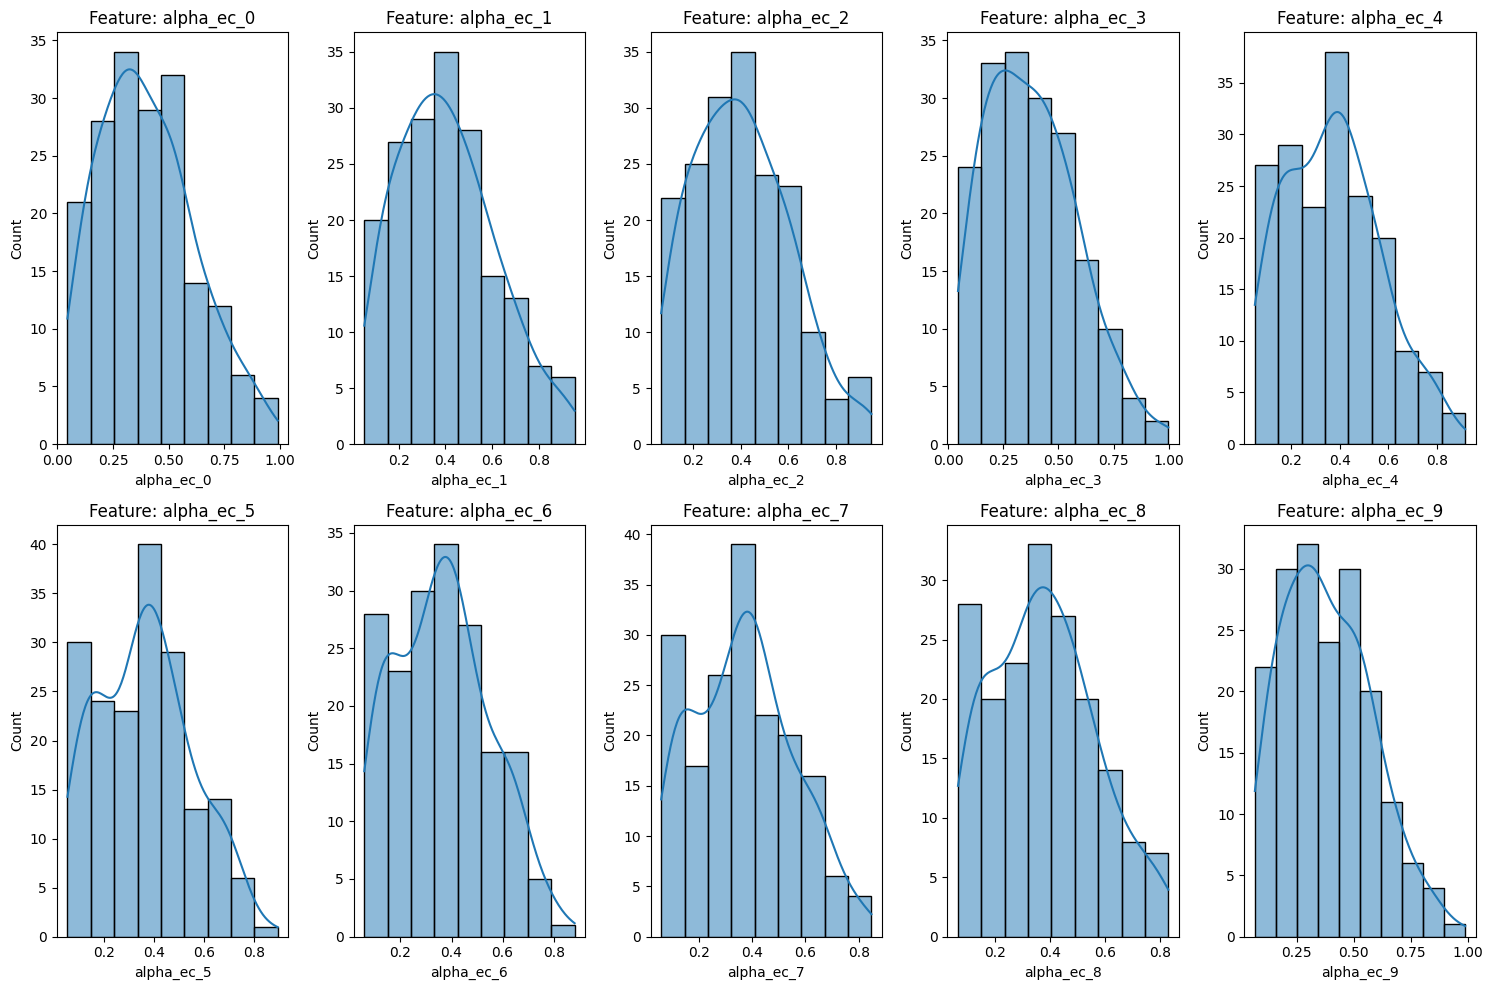

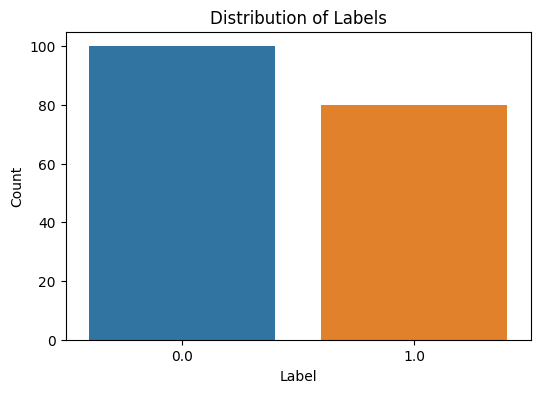

(       alpha_ec_0  alpha_ec_1  alpha_ec_2  alpha_ec_3  alpha_ec_4  alpha_ec_5  \
 count  180.000000  180.000000  180.000000  180.000000  180.000000  180.000000   
 mean     0.403767    0.406051    0.404508    0.378024    0.370230    0.363051   
 std      0.212651    0.208703    0.203369    0.207096    0.194484    0.188324   
 min      0.045305    0.052493    0.064302    0.045197    0.052021    0.054035   
 25%      0.240980    0.249482    0.258088    0.209325    0.209490    0.198185   
 50%      0.377190    0.384445    0.390135    0.358825    0.372940    0.360960   
 75%      0.540840    0.541517    0.544342    0.511320    0.503810    0.486233   
 max      0.991070    0.952930    0.950500    0.998370    0.914860    0.893100   
 
        alpha_ec_6  alpha_ec_7  alpha_ec_8  alpha_ec_9  ...  ratio_theta_38  \
 count  180.000000  180.000000  180.000000  180.000000  ...      180.000000   
 mean     0.363476    0.369076    0.377025    0.384056  ...        0.999865   
 std      0.186206    0

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Basic statistical summary of the data
data_description = data.describe()

# Checking for missing values in the data
missing_values = data.isnull().sum().sum()

# Distribution of labels (to understand the balance between classes)
label_counts = labels[0].value_counts()

# Visualizing the distribution of a few features (selecting first 10 for demonstration)
plt.figure(figsize=(15, 10))
for i in range(1, 11):
    plt.subplot(2, 5, i)
    sns.histplot(data.iloc[:, i-1], kde=True)
    plt.title(f'Feature: {pd.read_csv(feature_names_file, header=None).iloc[0, i-1]}')
plt.tight_layout()

# Visualizing the label distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=labels[0])
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

(data_description, missing_values, label_counts)

### Preprocessing Steps

In [5]:
from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer

# Create an instance of the LabelEncoder
label_encoder = LabelEncoder()

# Loop through each column in X that is of object type (usually string type in pandas)
for column in X.select_dtypes(include=['object']).columns:
    X[column] = label_encoder.fit_transform(X[column])

# KBinsDiscretizer discretizes continuous data into k bins
y_processed = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='uniform').fit_transform(y.values.reshape(-1, 1)).flatten()

/home/alex/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


### Feature Filtering Methods

---

#### Optimization of parameters for SVM & KNN



In [6]:
from sklearn.model_selection import LeaveOneGroupOut, GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

X_train = X.values
y_train = pd.DataFrame(y_processed, columns=['Label'])

groups = [i // 10 for i in range(data.shape[0])]

# Define parameter grid for SVM
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf', 'poly']
}

# Define parameter grid for KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'p': [1, 2],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Setup cross-validator
logo = LeaveOneGroupOut()

# Setup and perform GridSearchCV for SVM
grid_search_svm = GridSearchCV(SVC(), param_grid_svm, cv=logo)
grid_search_svm.fit(X_train, y_train.values.ravel(), groups=groups)
print("Best parameters for SVM:", grid_search_svm.best_params_)
print("SVM Best Score:", grid_search_svm.best_score_)

# Setup and perform GridSearchCV for KNN
grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=logo)
grid_search_knn.fit(X_train, y_train.values.ravel(), groups=groups)
print("Best parameters for KNN:", grid_search_knn.best_params_)
print("KNN Best Score:", grid_search_knn.best_score_)


Best parameters for SVM: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
SVM Best Score: 0.8722222222222222
Best parameters for KNN: {'metric': 'manhattan', 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
KNN Best Score: 0.7944444444444446


#### Get scores for the features

In [7]:
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif

# Get p and f values
p_values, f_statistic = f_classif(X, y_processed)

# Get chi2 value
chi2_scores, _ = chi2(X, y_processed)

# Get mutual info
mutual_info_scores = mutual_info_classif(X, y_processed)

# Create a DataFrame with the feature scores
f_scores = pd.DataFrame({
    'Feature': X.columns,
    'P_values': p_values,
    'Chi2': chi2_scores,
    'F_values': f_statistic,
    'Mutual_Information': mutual_info_scores
})

# Calculate the sum of scores for each feature
f_scores['Sum'] = f_scores[['P_values', 'Chi2', 'F_values', 'Mutual_Information']].sum(axis=1)

# Rank the features based on the sum of scores
f_scores_ranked = f_scores.sort_values(by='Sum', ascending=False)

# Print the ranked features with the desired columns
print(f_scores_ranked[['Feature', 'P_values', 'Chi2', 'F_values', 'Mutual_Information', 'Sum']])

           Feature   P_values        Chi2      F_values  Mutual_Information  \
293  ratio_alpha_5   6.499659  125.831095  1.163308e-02            0.083703   
370  ratio_beta_34  50.515116    7.008998  2.752280e-11            0.106034   
371  ratio_beta_35  40.234428    7.030647  1.804678e-09            0.108232   
291  ratio_alpha_3  16.402362   30.121341  7.635829e-05            0.044410   
373  ratio_beta_37  39.018106    7.225004  3.003193e-09            0.135265   
..             ...        ...         ...           ...                 ...   
162    alpha_eo_18   0.093941    0.005983  7.595843e-01            0.000000   
75      beta_ec_27   0.152239    0.009319  6.968718e-01            0.000000   
198      beta_eo_6   0.104770    0.006631  7.465586e-01            0.000000   
163    alpha_eo_19   0.108481    0.006296  7.422676e-01            0.000000   
243     theta_eo_3   0.131497    0.002849  7.173152e-01            0.000000   

            Sum  
293  132.426091  
370   57.630149

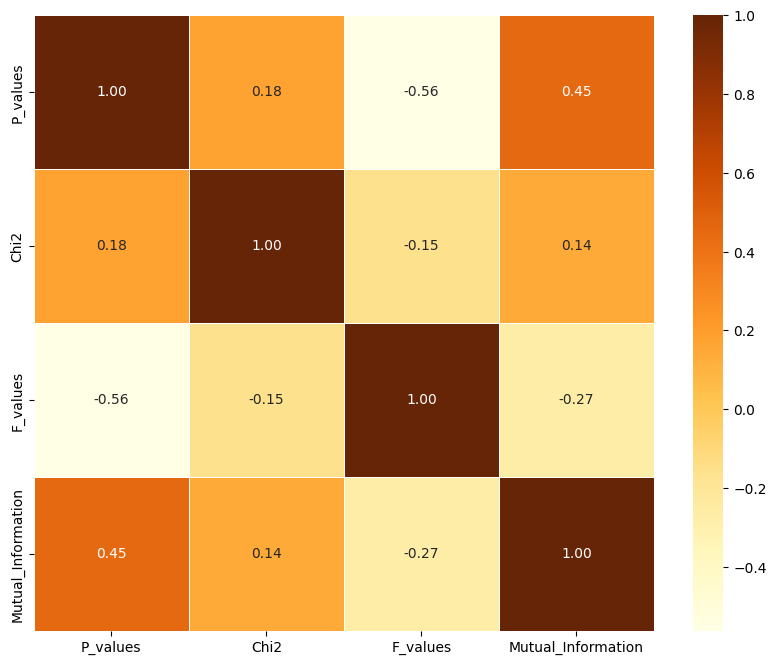

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = f_scores[['P_values', 'Chi2','F_values' ,'Mutual_Information']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='YlOrBr', fmt='.2f', linewidths=0.5)
plt.show()

this is the baseline. no chi2, just LOO on SVM and KNN. The final value of accuracy is the mean of all groups

SVM Results:
Accuracies: [0.8722222222222222, 0.8722222222222222, 0.8722222222222222, 0.8722222222222222, 0.8722222222222222, 0.8722222222222222, 0.8722222222222222, 0.8722222222222222, 0.8722222222222222, 0.8722222222222222, 0.8722222222222222, 0.8722222222222222, 0.8722222222222222, 0.8722222222222222, 0.8722222222222222, 0.8722222222222222, 0.8722222222222222, 0.8722222222222222]
Sensitivities: [0.2611111111111111, 0.2611111111111111, 0.2611111111111111, 0.2611111111111111, 0.2611111111111111, 0.2611111111111111, 0.2611111111111111, 0.2611111111111111, 0.2611111111111111, 0.2611111111111111, 0.2611111111111111, 0.2611111111111111, 0.2611111111111111, 0.2611111111111111, 0.2611111111111111, 0.2611111111111111, 0.2611111111111111, 0.2611111111111111]
Specificities: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.

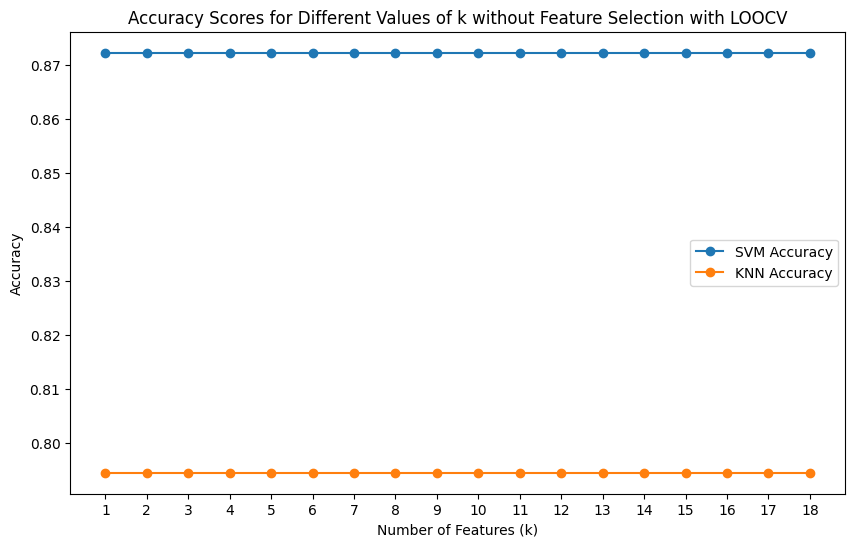

In [33]:
groups = np.repeat(np.arange(1, 19), 10)

# Initialize lists to store accuracy, sensitivity, specificity, and standard deviation scores
svm_accuracies = []
svm_sensitivities = []
svm_specificities = []
svm_accuracy_std = []
svm_sensitivity_std = []
svm_specificity_std = []

knn_accuracies = []
knn_sensitivities = []
knn_specificities = []
knn_accuracy_std = []
knn_sensitivity_std = []
knn_specificity_std = []

for k in range(1, 19):  # You can adjust the range based on your requirements
    loo = LeaveOneGroupOut()

    svm_accuracy_group = []
    svm_sensitivity_group = []
    svm_specificity_group = []

    knn_accuracy_group = []
    knn_sensitivity_group = []
    knn_specificity_group = []

    for train_index, test_index in loo.split(data, labels, groups):
        X_train, X_test = data.iloc[train_index], data.iloc[test_index]
        y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]

        # Train SVM model without feature selection
        svm_model = SVC(C=1, gamma='scale', kernel='linear')
        svm_model.fit(X_train, y_train.values.ravel())
        svm_predictions = svm_model.predict(X_test)

        # Calculate sensitivity and specificity for SVM
        conf_matrix_svm = confusion_matrix(y_test, svm_predictions)

        # Ensure it's a 2x2 array
        if conf_matrix_svm.shape == (2, 2):
            tn, fp, fn, tp = conf_matrix_svm.ravel()
        else:
            # Handle the case where the confusion matrix has a different shape (e.g., due to multi-class)
            # You can choose how to handle it, for example, by setting all values to 0
            tn, fp, fn, tp = 0, 0, 0, 0

        # Avoid division by zero
        denominator_sensitivity = (tp + fn) if (tp + fn != 0) else 1
        denominator_specificity = (tn + fp) if (tn + fp != 0) else 1

        # Calculate sensitivity and specificity
        sensitivity = tp / denominator_sensitivity
        specificity = tn / denominator_specificity

        # Now, you can append sensitivity and specificity to the respective lists
        svm_accuracy_group.append(accuracy_score(y_test, svm_predictions))
        svm_sensitivity_group.append(sensitivity)
        svm_specificity_group.append(specificity)

        # Train KNN model without feature selection
        knn_model = KNeighborsClassifier(n_neighbors=3, p=1, weights='uniform')
        knn_model.fit(X_train, y_train.values.ravel())
        knn_predictions = knn_model.predict(X_test)

        # Calculate sensitivity and specificity for KNN
        conf_matrix_knn = confusion_matrix(y_test, knn_predictions)
        conf_matrix_knn = np.squeeze(conf_matrix_knn)  # Ensure it's a 1D array

        if conf_matrix_knn.ndim == 0:  # Check if it's a 0-dimensional array
            tn, fp, fn, tp = 0, 0, 0, conf_matrix_knn[()]
        else:
            tn, fp, fn, tp = conf_matrix_knn[0], 0, 0, conf_matrix_knn[1]

        # Avoid division by zero
        denominator_sensitivity = (tp + fn) if np.any(tp + fn) else 1
        denominator_specificity = (tn + fp) if np.any(tn + fp) else 1

        # Check if denominator is not zero before performing division
        sensitivity = tp / denominator_sensitivity
        specificity = tn / denominator_specificity

        knn_accuracy_group.append(accuracy_score(y_test, knn_predictions))
        knn_sensitivity_group.append(sensitivity)
        knn_specificity_group.append(specificity)

    # Take the mean and standard deviation across all groups for SVM
    svm_accuracies.append(np.mean(svm_accuracy_group))
    svm_sensitivities.append(np.mean(svm_sensitivity_group))
    svm_specificities.append(np.mean(svm_specificity_group))
    svm_accuracy_std.append(np.std(svm_accuracy_group))
    svm_sensitivity_std.append(np.std(svm_sensitivity_group))
    svm_specificity_std.append(np.std(svm_specificity_group))

    # Take the mean and standard deviation across all groups for KNN
    knn_accuracies.append(np.mean(knn_accuracy_group))
    knn_sensitivities.append(np.mean(knn_sensitivity_group))
    knn_specificities.append(np.mean(knn_specificity_group))
    knn_accuracy_std.append(np.std(knn_accuracy_group))
    knn_sensitivity_std.append(np.std(knn_sensitivity_group))
    knn_specificity_std.append(np.std(knn_specificity_group))

# Print the results
print("SVM Results:")
print("Accuracies:", svm_accuracies)
print("Sensitivities:", svm_sensitivities)
print("Specificities:", svm_specificities)
print("Standard Deviations - Accuracy:", svm_accuracy_std)
print("Standard Deviations - Sensitivity:", svm_sensitivity_std)
print("Standard Deviations - Specificity:", svm_specificity_std)

print("\nKNN Results:")
print("Accuracies:", knn_accuracies)
print("Sensitivities:", knn_sensitivities)
print("Specificities:", knn_specificities)
print("Standard Deviations - Accuracy:", knn_accuracy_std)
print("Standard Deviations - Sensitivity:", knn_sensitivity_std)
print("Standard Deviations - Specificity:", knn_specificity_std)

# Find the maximum accuracy and corresponding number of features for SVM and KNN
max_svm_accuracy = max(svm_accuracies)
max_svm_k = svm_accuracies.index(max_svm_accuracy) + 1  # Adding 1 because the index starts from 0
max_svm_sensitivity = svm_sensitivities[svm_accuracies.index(max_svm_accuracy)]
max_svm_specificity = svm_specificities[svm_accuracies.index(max_svm_accuracy)]
max_svm_accuracy_std = svm_accuracy_std[svm_accuracies.index(max_svm_accuracy)]
max_svm_sensitivity_std = svm_sensitivity_std[svm_accuracies.index(max_svm_accuracy)]
max_svm_specificity_std = svm_specificity_std[svm_accuracies.index(max_svm_accuracy)]

max_knn_accuracy = max(knn_accuracies)
max_knn_k = knn_accuracies.index(max_knn_accuracy) + 1  # Adding 1 because the index starts from 0
max_knn_sensitivity = knn_sensitivities[knn_accuracies.index(max_knn_accuracy)]
max_knn_specificity = knn_specificities[knn_accuracies.index(max_knn_accuracy)]
max_knn_accuracy_std = knn_accuracy_std[knn_accuracies.index(max_knn_accuracy)]
max_knn_sensitivity_std = knn_sensitivity_std[knn_accuracies.index(max_knn_accuracy)]
max_knn_specificity_std = knn_specificity_std[knn_accuracies.index(max_knn_accuracy)]

print("\nMax SVM Accuracy:")
print(f"Accuracy: {max_svm_accuracy} for k = {max_svm_k}, Sensitivity = {max_svm_sensitivity}, Specificity = {max_svm_specificity}")
print(f"Standard Deviations - Accuracy: {max_svm_accuracy_std}, Sensitivity: {max_svm_sensitivity_std}, Specificity: {max_svm_specificity_std}")

print("\nMax KNN Accuracy:")
print(f"Accuracy: {max_knn_accuracy} for k = {max_knn_k}, Sensitivity = {max_knn_sensitivity}, Specificity = {max_knn_specificity}")
print(f"Standard Deviations - Accuracy: {max_knn_accuracy_std}, Sensitivity: {max_knn_sensitivity_std}, Specificity: {max_knn_specificity_std}")

# Plot the accuracy scores for different values of k
plt.figure(figsize=(10, 6))
plt.plot(range(1, 19), svm_accuracies, marker='o', label='SVM Accuracy')
plt.plot(range(1, 19), knn_accuracies, marker='o', label='KNN Accuracy')
plt.xlabel('Number of Features (k)')
plt.ylabel('Accuracy')
plt.title('Accuracy Scores for Different Values of k without Feature Selection with LOOCV')
plt.xticks(range(1, 19))  # Assuming you have 18 groups/subjects
plt.legend()
plt.show()

SVM Results:
Accuracy: Mean = 0.8722222222222222 Std = 0.10437941237808855
Sensitivity: Mean = 0.2611111111111111 Std = 0.3713921091857393
Specificity: Mean = 0.6111111111111112 Std = 0.4382907316292449

KNN Results:
Accuracy: Mean = 0.7944444444444446 Std = 0.07049209744694179
Sensitivity: Mean = 0.33888888888888885 Std = 0.38171963080670857
Specificity: Mean = 0.4555555555555556 Std = 0.4099081499043715


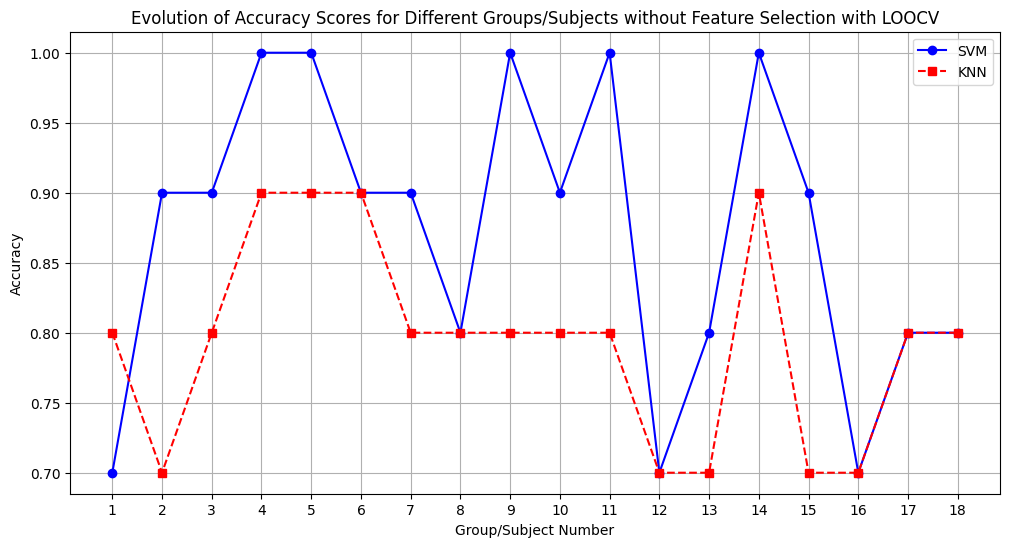

In [43]:
groups = np.repeat(np.arange(18), 10)

# Initialize lists to store metrics for SVM
svm_metrics = {
    'accuracy': [],
    'sensitivity': [],
    'specificity': []
}

# Initialize lists to store metrics for KNN
knn_metrics = {
    'accuracy': [],
    'sensitivity': [],
    'specificity': []
}

# Initialize lists to store accuracies for each group/subject for SVM and KNN
svm_accuracies = []
knn_accuracies = []

# Initialize LeaveOneGroupOut cross-validator
logo = LeaveOneGroupOut()

# Iterate over each group defined by 'groups'
for train_index, test_index in logo.split(data, labels, groups):
    # Split the data into training and test sets for this iteration
    X_train, X_test = data.iloc[train_index], data.iloc[test_index]
    y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]

    # SVM Classifier
    svm = SVC(C=1, gamma='scale', kernel='linear')
    svm.fit(X_train, y_train.values.ravel())
    y_pred_svm = svm.predict(X_test)
    svm_accuracies.append(accuracy_score(y_test, svm.predict(X_test)))
    
    # KNN Classifier
    knn = KNeighborsClassifier(n_neighbors=3, metric='manhattan', weights='uniform')
    knn.fit(X_train, y_train.values.ravel())
    y_pred_knn = knn.predict(X_test)
    knn_accuracies.append(accuracy_score(y_test, knn.predict(X_test)))

    # Calculate metrics for SVM
    cm = confusion_matrix(y_test, y_pred_svm)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (cm[0,0], 0, 0, 0) if cm[0,0] else (0, 0, 0, cm[1,1])
    svm_metrics['accuracy'].append(accuracy_score(y_test, y_pred_svm))
    svm_metrics['sensitivity'].append(tp / (tp + fn) if tp + fn > 0 else 0)
    svm_metrics['specificity'].append(tn / (tn + fp) if tn + fp > 0 else 0)

    # Calculate metrics for KNN
    cm = confusion_matrix(y_test, y_pred_knn)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (cm[0,0], 0, 0, 0) if cm[0,0] else (0, 0, 0, cm[1,1])
    knn_metrics['accuracy'].append(accuracy_score(y_test, y_pred_knn))
    knn_metrics['sensitivity'].append(tp / (tp + fn) if tp + fn > 0 else 0)
    knn_metrics['specificity'].append(tn / (tn + fp) if tn + fp > 0 else 0)

# Convert lists to numpy arrays for easy mean and standard deviation calculations
for metric in svm_metrics:
    svm_metrics[metric] = np.array(svm_metrics[metric])

for metric in knn_metrics:
    knn_metrics[metric] = np.array(knn_metrics[metric])

# Print the results
print("SVM Results:")
print("Accuracy: Mean =", svm_metrics['accuracy'].mean(), "Std =", svm_metrics['accuracy'].std())
print("Sensitivity: Mean =", svm_metrics['sensitivity'].mean(), "Std =", svm_metrics['sensitivity'].std())
print("Specificity: Mean =", svm_metrics['specificity'].mean(), "Std =", svm_metrics['specificity'].std())

print("\nKNN Results:")
print("Accuracy: Mean =", knn_metrics['accuracy'].mean(), "Std =", knn_metrics['accuracy'].std())
print("Sensitivity: Mean =", knn_metrics['sensitivity'].mean(), "Std =", knn_metrics['sensitivity'].std())
print("Specificity: Mean =", knn_metrics['specificity'].mean(), "Std =", knn_metrics['specificity'].std())

# Plot the evolution of accuracy scores for SVM and KNN
plt.figure(figsize=(12, 6))
plt.plot(range(1, 19), svm_accuracies, label='SVM', marker='o', linestyle='-', color='blue')
plt.plot(range(1, 19), knn_accuracies, label='KNN', marker='s', linestyle='--', color='red')
plt.xlabel('Group/Subject Number')
plt.ylabel('Accuracy')
plt.title('Evolution of Accuracy Scores for Different Groups/Subjects without Feature Selection with LOOCV')
plt.xticks(range(1, 19))  # Assuming you have 18 groups/subjects
plt.legend()
plt.grid(True)
plt.show()

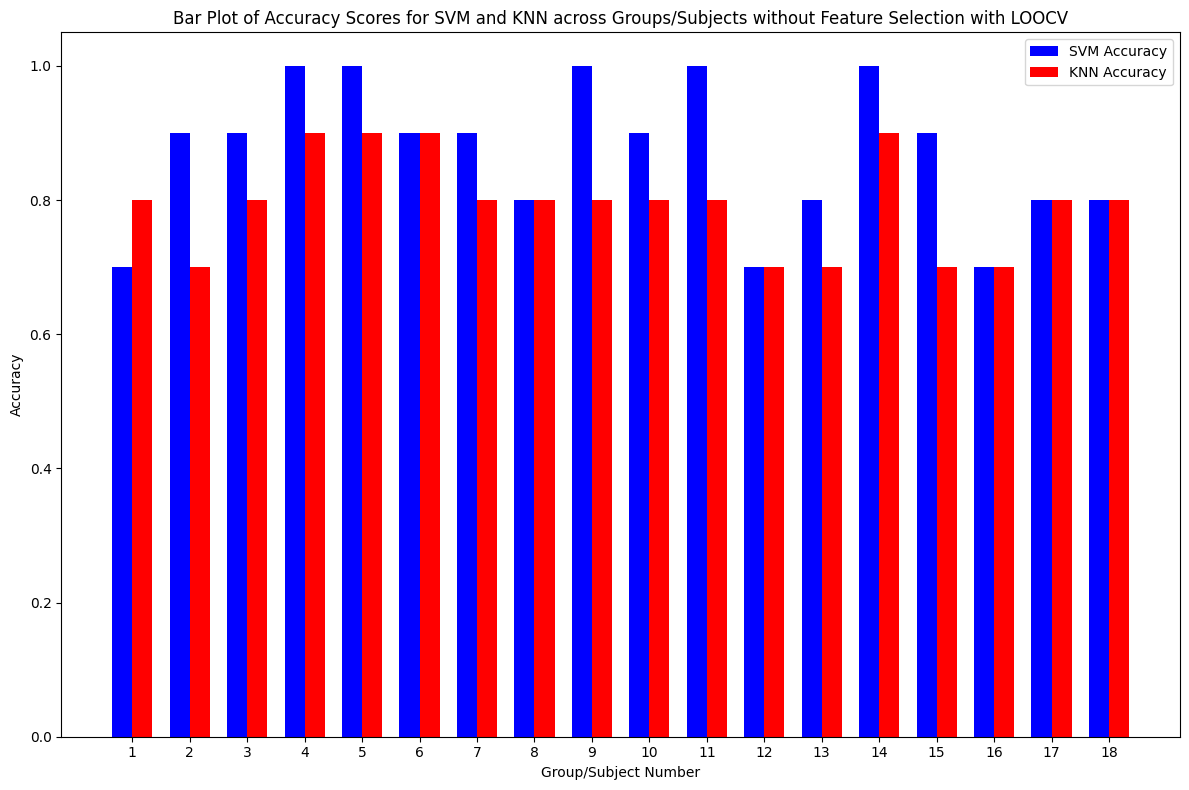

In [44]:
# Plotting bar chart for the mean accuracy of SVM and KNN
bar_width = 0.35  # Width of the bars
index = np.arange(len(svm_accuracies))  # Group positions

plt.figure(figsize=(12, 8))
plt.bar(index, svm_accuracies, bar_width, label='SVM Accuracy', color='b')
plt.bar(index + bar_width, knn_accuracies, bar_width, label='KNN Accuracy', color='r')

plt.xlabel('Group/Subject Number')
plt.ylabel('Accuracy')
plt.title('Bar Plot of Accuracy Scores for SVM and KNN across Groups/Subjects without Feature Selection with LOOCV')
plt.xticks(index + bar_width / 2, (index + 1))  # Set the position of the x ticks
plt.legend()
plt.tight_layout()
plt.show()

this is filter chi2, LOOCV and optimizaiton on SVM and KNN

SVM Standard Deviations:
Accuracy: [0.4496912521077347, 0.09111788592698183, 0.11772011166898384, 0.11331154474650636, 0.11180339887498951, 0.1166666666666667, 0.13111581912451054, 0.13743685418725535, 0.12472191289246472, 0.1067187372905475, 0.1067187372905475, 0.13799713720415804, 0.13664859862498716, 0.14487116456005888, 0.14487116456005888, 0.14865653511399615, 0.1470911366097081, 0.15365907428821482, 0.1660172533053771, 0.16263645742560498, 0.1879880479520959, 0.16072751268321592, 0.14989708403591157, 0.14958791130929178, 0.11613636089092709, 0.11331154474650634, 0.10437941237808857, 0.11166528467912103, 0.10613873985857114, 0.11666666666666668, 0.11811273125260723, 0.11811273125260723, 0.10304020550550784, 0.10137937550497035, 0.10258991840344106, 0.10999438818457408, 0.12018504251546634, 0.10957268290731124, 0.12862041003100252, 0.13698697784375502, 0.12234841969747356, 0.13111581912451054, 0.12583057392117916, 0.13844373104863458, 0.14624940645653536, 0.1301708279317776, 0.1369

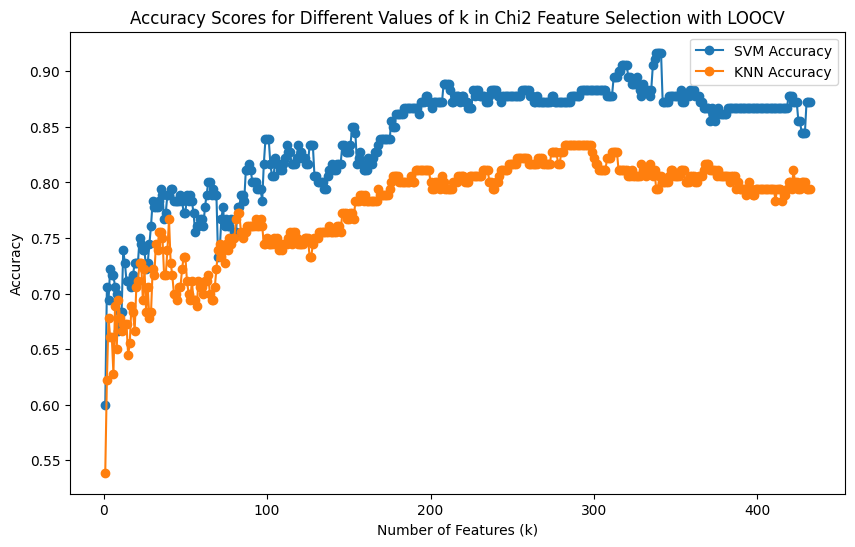

In [11]:
groups = np.repeat(np.arange(1, 19), 10)

# Initialize lists to store accuracy, sensitivity, and specificity scores
svm_accuracies = []
svm_sensitivities = []
svm_specificities = []
svm_accuracy_std = []
svm_sensitivity_std = []
svm_specificity_std = []

knn_accuracies = []
knn_sensitivities = []
knn_specificities = []
knn_accuracy_std = []
knn_sensitivity_std = []
knn_specificity_std = []

# Try different values of k for chi2 feature selection
for k in range(1, 433):  # You can adjust the range based on your requirements
    loo = LeaveOneGroupOut()

    # Apply chi2 feature selection
    chi2_selector = SelectKBest(chi2, k=k)
    data_chi2 = chi2_selector.fit_transform(data.astype(object), labels)

    svm_accuracy_group = []
    svm_sensitivity_group = []
    svm_specificity_group = []

    knn_accuracy_group = []
    knn_sensitivity_group = []
    knn_specificity_group = []

    for train_index, test_index in loo.split(data_chi2, labels, groups):
        X_train, X_test = data_chi2[train_index], data_chi2[test_index]
        y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]

        data_chi2_train = chi2_selector.fit_transform(X_train, y_train.values.ravel())
        data_chi2_test = chi2_selector.transform(X_test)

        # Train SVM model
        svm_model = SVC(C=1, gamma='scale', kernel='linear')
        svm_model.fit(data_chi2_train, y_train.values.ravel())
        svm_predictions = svm_model.predict(data_chi2_test)

        # Calculate sensitivity and specificity for SVM
        conf_matrix_svm = confusion_matrix(y_test, svm_predictions)

        if conf_matrix_svm.shape == (2, 2):
            tn, fp, fn, tp = conf_matrix_svm.ravel()
        else:
            # Handle cases where the confusion matrix shape is different
            tn, fp, fn, tp = 0, 0, 0, 0

        # Avoid division by zero
        denominator_sensitivity = (tp + fn) if (tp + fn != 0) else 1
        denominator_specificity = (tn + fp) if (tn + fp != 0) else 1

        # Calculate sensitivity and specificity
        sensitivity = tp / denominator_sensitivity
        specificity = tn / denominator_specificity

        svm_accuracy_group.append(accuracy_score(y_test, svm_predictions))
        svm_sensitivity_group.append(sensitivity)
        svm_specificity_group.append(specificity)

        # Train KNN model
        knn_model = KNeighborsClassifier(n_neighbors=3, p=1, weights='uniform')
        knn_model.fit(data_chi2_train, y_train.values.ravel())
        knn_predictions = knn_model.predict(data_chi2_test)

        # Calculate sensitivity and specificity for KNN
        conf_matrix_knn = confusion_matrix(y_test, knn_predictions)

        if conf_matrix_knn.shape == (2, 2):
            tn, fp, fn, tp = conf_matrix_knn.ravel()
        else:
            # Handle cases where the confusion matrix shape is different
            tn, fp, fn, tp = 0, 0, 0, 0

        # Avoid division by zero
        denominator_sensitivity = (tp + fn) if (tp + fn != 0) else 1
        denominator_specificity = (tn + fp) if (tn + fp != 0) else 1

        # Check if denominator is not zero before performing division
        sensitivity = tp / denominator_sensitivity
        specificity = tn / denominator_specificity

        knn_accuracy_group.append(accuracy_score(y_test, knn_predictions))
        knn_sensitivity_group.append(np.array([sensitivity]))
        knn_specificity_group.append(specificity)

    # Take the mean and standard deviation across all groups for SVM
    svm_accuracies.append(np.mean(svm_accuracy_group))
    svm_sensitivities.append(np.mean(svm_sensitivity_group))
    svm_specificities.append(np.mean(svm_specificity_group))
    svm_accuracy_std.append(np.std(svm_accuracy_group))
    svm_sensitivity_std.append(np.std(svm_sensitivity_group))
    svm_specificity_std.append(np.std(svm_specificity_group))

    # Take the mean and standard deviation across all groups for KNN
    knn_accuracies.append(np.mean(knn_accuracy_group))
    knn_sensitivities.append(np.mean(knn_sensitivity_group))
    knn_specificities.append(np.mean(knn_specificity_group))
    knn_accuracy_std.append(np.std(knn_accuracy_group))
    knn_sensitivity_std.append(np.std(knn_sensitivity_group))
    knn_specificity_std.append(np.std(knn_specificity_group))


# Print the standard deviations
print("SVM Standard Deviations:")
print("Accuracy:", svm_accuracy_std)
print("Sensitivity:", svm_sensitivity_std)
print("Specificity:", svm_specificity_std)

print("\nKNN Standard Deviations:")
print("Accuracy:", knn_accuracy_std)
print("Sensitivity:", knn_sensitivity_std)
print("Specificity:", knn_specificity_std)

# Find the maximum accuracy and corresponding number of features for SVM and KNN
max_svm_accuracy = max(svm_accuracies)
max_svm_k = svm_accuracies.index(max_svm_accuracy) + 1  # Adding 1 because the index starts from 0
max_svm_sensitivity = svm_sensitivities[svm_accuracies.index(max_svm_accuracy)]
max_svm_specificity = svm_specificities[svm_accuracies.index(max_svm_accuracy)]
max_svm_accuracy_std = svm_accuracy_std[svm_accuracies.index(max_svm_accuracy)]
max_svm_sensitivity_std = svm_sensitivity_std[svm_accuracies.index(max_svm_accuracy)]
max_svm_specificity_std = svm_specificity_std[svm_accuracies.index(max_svm_accuracy)]

max_knn_accuracy = max(knn_accuracies)
max_knn_k = knn_accuracies.index(max_knn_accuracy) + 1  # Adding 1 because the index starts from 0
max_knn_sensitivity = knn_sensitivities[knn_accuracies.index(max_knn_accuracy)]
max_knn_specificity = knn_specificities[knn_accuracies.index(max_knn_accuracy)]
max_knn_accuracy_std = knn_accuracy_std[knn_accuracies.index(max_knn_accuracy)]
max_knn_sensitivity_std = knn_sensitivity_std[knn_accuracies.index(max_knn_accuracy)]
max_knn_specificity_std = knn_specificity_std[knn_accuracies.index(max_knn_accuracy)]

print("\nMax SVM Accuracy:")
print(f"Accuracy: {max_svm_accuracy} for k = {max_svm_k}, Sensitivity = {max_svm_sensitivity}, Specificity = {max_svm_specificity}")
print(f"Standard Deviations - Accuracy: {max_svm_accuracy_std}, Sensitivity: {max_svm_sensitivity_std}, Specificity: {max_svm_specificity_std}")

print("\nMax KNN Accuracy:")
print(f"Accuracy: {max_knn_accuracy} for k = {max_knn_k}, Sensitivity = {max_knn_sensitivity}, Specificity = {max_knn_specificity}")
print(f"Standard Deviations - Accuracy: {max_knn_accuracy_std}, Sensitivity: {max_knn_sensitivity_std}, Specificity: {max_knn_specificity_std}")


# Plot the accuracy scores for different values of k
plt.figure(figsize=(10, 6))
plt.plot(range(1, 433), svm_accuracies, marker='o', label='SVM Accuracy')
plt.plot(range(1, 433), knn_accuracies, marker='o', label='KNN Accuracy')
plt.xlabel('Number of Features (k)')
plt.ylabel('Accuracy')
plt.title('Accuracy Scores for Different Values of k in Chi2 Feature Selection with LOOCV')
plt.legend()
plt.show()

### Feature Embedding Methods

---

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Embedding, Flatten
from keras.regularizers import l1
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import Lasso

#### Looking for the optimal parameters

In [ ]:
#import fiel
File_read = pd.read_csv('csv/data.csv', header=None)
feature_sets = File_read.to_numpy()
#set labels
labels = np.array([0] * 100 + [1] * 80)
#set Group for KFold
K= KFold(18)
#create classifiers

L1_list = [0.01,0.02,0.03,0.04,0.05,0.06,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5]

X_X = [mm for mm in range(1,61,1)]

#for SVM
accuracy_list = []
sensitivity_list = []
specificity_list = []
#for KNN
accuracy_list2 = []
sensitivity_list2 = []
specificity_list2 = []

In [ ]:
for j in L1_list:
        y_predict_svm_embed    = []
        y_predict_knn_embed    = []
        svm_classifier = SVC(kernel='linear')
        knn_classifier = KNeighborsClassifier(n_neighbors=6)
  
        #create an Embedding model
        lasso_model = Lasso(alpha = j)

        #Kford
        for train_index, test_index in K.split(feature_sets):

            X_train, X_test = feature_sets[train_index], feature_sets[test_index]
            y_train, y_test = labels[train_index], labels[test_index]
            
            # feature_selection for train model:
            lasso_model.fit(X_train,y_train)
            feature_weights = lasso_model.coef_
            selected_features = np.where(lasso_model.coef_ != 0)[0]
            X_train_select = X_train[:,selected_features]
            X_test_select  = X_test[:,selected_features]

            # SVM
            
            svm_classifier.fit(X_train_select, y_train)
            y_pred = svm_classifier.predict(X_test_select)
            y_predict_svm_embed = y_predict_svm_embed + list(y_pred)

            # KNN
            
            knn_classifier.fit(X_train_select, y_train)
            y_pred = knn_classifier.predict(X_test_select)
            y_predict_knn_embed = y_predict_knn_embed + list(y_pred)

        #confusion for accuracy ,sensitivity, specificity
        confusion_svm = confusion_matrix(labels,np.array(y_predict_svm_embed))
        accuracy = (confusion_svm[0,0]+confusion_svm[1,1])/(confusion_svm[0,0]+confusion_svm[0,1]+confusion_svm[1,0]+confusion_svm[1,1])
        specificity = confusion_svm[0, 0] / (confusion_svm[0, 0] + confusion_svm[0, 1])
        sensitivity = confusion_svm[1, 1] / (confusion_svm[1, 0] + confusion_svm[1, 1])
        accuracy_list.append(accuracy)
        sensitivity_list.append(sensitivity)
        specificity_list.append(specificity)
        
        confusion = confusion_matrix(labels,y_predict_knn_embed)
        accuracy = (confusion[0,0]+confusion[1,1])/(confusion[0,0]+confusion[0,1]+confusion[1,0]+confusion[1,1])
        specificity= confusion[0, 0] / (confusion[0, 0] + confusion[0, 1])
        sensitivity = confusion[1, 1] / (confusion[1, 0] + confusion[1, 1])
        accuracy_list2.append(accuracy)
        sensitivity_list2.append(sensitivity)
        specificity_list2.append(specificity)
        '''
        plt.bar(range(len(feature_weights)),abs(feature_weights))
        plt.title(f'Lasso with L1(alpha = {j})')
        plt.ylabel('|w|')
        plt.xlabel('Feature Index')
        plt.show()'''

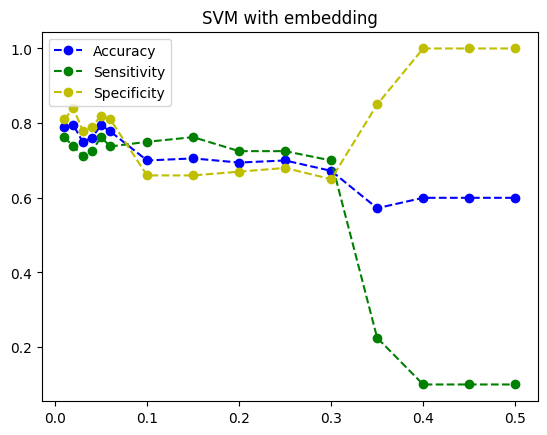

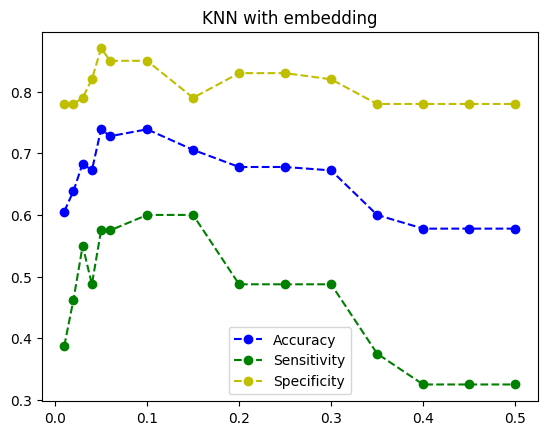

In [ ]:
plt.plot(L1_list,accuracy_list,'bo--')
plt.plot(L1_list,sensitivity_list,'go--')
plt.plot(L1_list,specificity_list,'yo--')
plt.legend(['Accuracy','Sensitivity','Specificity'])
plt.title('SVM with embedding')
plt.show()
plt.plot(L1_list,accuracy_list2,'bo--')
plt.plot(L1_list,sensitivity_list2,'go--')
plt.plot(L1_list,specificity_list2,'yo--')
plt.legend(['Accuracy','Sensitivity','Specificity'])
plt.title('KNN with embedding')
plt.show()

#### Outcome with the optimal parameters

In [ ]:
y_predict_svm_embed    = []
y_predict_svm_no_embed = []
y_predict_knn_embed    = []
y_predict_knn_no_embed = []
svm_classifier = SVC(kernel='linear')
knn_classifier = KNeighborsClassifier(n_neighbors=6)
svm_without_embed = SVC(kernel = 'linear')
knn_without_embed = KNeighborsClassifier(n_neighbors=6)
lasso_model = Lasso(alpha = 0.1)
#Kford
for train_index, test_index in K.split(feature_sets):

    X_train, X_test = feature_sets[train_index], feature_sets[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    
    # select features
    lasso_model.fit(X_train,y_train)
    feature_weights = lasso_model.coef_
    selected_features = np.where(lasso_model.coef_ != 0)[0]
    X_train_select = X_train[:,selected_features]
    X_test_select  = X_test[:,selected_features]

    # SVM
    
    svm_classifier.fit(X_train_select, y_train)
    y_pred = svm_classifier.predict(X_test_select)
    y_predict_svm_embed = y_predict_svm_embed + list(y_pred)

    # KNN
    
    knn_classifier.fit(X_train_select, y_train)
    y_pred = knn_classifier.predict(X_test_select)
    y_predict_knn_embed = y_predict_knn_embed + list(y_pred)

    # SVM withou embedding
    
    svm_without_embed.fit(X_train,y_train)
    y_pred = svm_without_embed.predict(X_test)
    y_predict_svm_no_embed = y_predict_svm_no_embed + list(y_pred)
    # KNN without embedding
    
    knn_without_embed.fit(X_train,y_train)
    y_pred = knn_without_embed.predict(X_test)
    y_predict_knn_no_embed = y_predict_knn_no_embed + list(y_pred)

In [ ]:
#confusion for accuracy ,sensitivity, specificity
confusion_svm = confusion_matrix(labels,np.array(y_predict_svm_embed))
accuracy = (confusion_svm[0,0]+confusion_svm[1,1])/(confusion_svm[0,0]+confusion_svm[0,1]+confusion_svm[1,0]+confusion_svm[1,1])
specificity = confusion_svm[0, 0] / (confusion_svm[0, 0] + confusion_svm[0, 1])
sensitivity = confusion_svm[1, 1] / (confusion_svm[1, 0] + confusion_svm[1, 1])
print('SVM with    Embedding:')
print(f' Accuracy: {accuracy}')
print(f' Sensitivity: {sensitivity}')
print(f' Specificity: {specificity}')
print(' confusion is:\n',confusion_svm)
print("value of confusion: [0,0]->TN,[0,1]->FP,[1,0]->FN,[1,1]_>TP\n")
confusion = confusion_matrix(labels,y_predict_svm_no_embed)
accuracy = (confusion[0,0]+confusion[1,1])/(confusion[0,0]+confusion[0,1]+confusion[1,0]+confusion[1,1])
specificity= confusion[0, 0] / (confusion[0, 0] + confusion[0, 1])
sensitivity = confusion[1, 1] / (confusion[1, 0] + confusion[1, 1])
print('SVM without Embedding:')
print(f' Accuracy: {accuracy}')
print(f' Sensitivity: {sensitivity}')
print(f' Specificity: {specificity}')
print(' confusion is:\n',confusion)
print("value of confusion: [0,0]->TN,[0,1]->FP,[1,0]->FN,[1,1]_>TP\n")
confusion = confusion_matrix(labels,y_predict_knn_embed)
accuracy = (confusion[0,0]+confusion[1,1])/(confusion[0,0]+confusion[0,1]+confusion[1,0]+confusion[1,1])
specificity= confusion[0, 0] / (confusion[0, 0] + confusion[0, 1])
sensitivity = confusion[1, 1] / (confusion[1, 0] + confusion[1, 1])
print('KNN with    Embedding:')
print(f' Accuracy: {accuracy}')
print(f' Sensitivity: {sensitivity}')
print(f' Specificity: {specificity}')
print(' confusion is:\n',confusion)
print("value of confusion: [0,0]->TN,[0,1]->FP,[1,0]->FN,[1,1]_>TP\n")
confusion = confusion_matrix(labels,y_predict_knn_no_embed)
accuracy = (confusion[0,0]+confusion[1,1])/(confusion[0,0]+confusion[0,1]+confusion[1,0]+confusion[1,1])
specificity= confusion[0, 0] / (confusion[0, 0] + confusion[0, 1])
sensitivity = confusion[1, 1] / (confusion[1, 0] + confusion[1, 1])
print('KNN without Embedding:')
print(f' Accuracy: {accuracy}')
print(f' Sensitivity: {sensitivity}')
print(f' Specificity: {specificity}')
print(' confusion is:\n',confusion)
print("value of confusion: [0,0]->TN,[0,1]->FP,[1,0]->FN,[1,1]_>TP\n")

SVM with    Embedding:
 Accuracy: 0.7
 Sensitivity: 0.75
 Specificity: 0.66
 confusion is:
 [[66 34]
 [20 60]]
value of confusion: [0,0]->TN,[0,1]->FP,[1,0]->FN,[1,1]_>TP

SVM without Embedding:
 Accuracy: 0.8722222222222222
 Sensitivity: 0.8375
 Specificity: 0.9
 confusion is:
 [[90 10]
 [13 67]]
value of confusion: [0,0]->TN,[0,1]->FP,[1,0]->FN,[1,1]_>TP

KNN with    Embedding:
 Accuracy: 0.7388888888888889
 Sensitivity: 0.6
 Specificity: 0.85
 confusion is:
 [[85 15]
 [32 48]]
value of confusion: [0,0]->TN,[0,1]->FP,[1,0]->FN,[1,1]_>TP

KNN without Embedding:
 Accuracy: 0.6333333333333333
 Sensitivity: 0.3875
 Specificity: 0.83
 confusion is:
 [[83 17]
 [49 31]]
value of confusion: [0,0]->TN,[0,1]->FP,[1,0]->FN,[1,1]_>TP



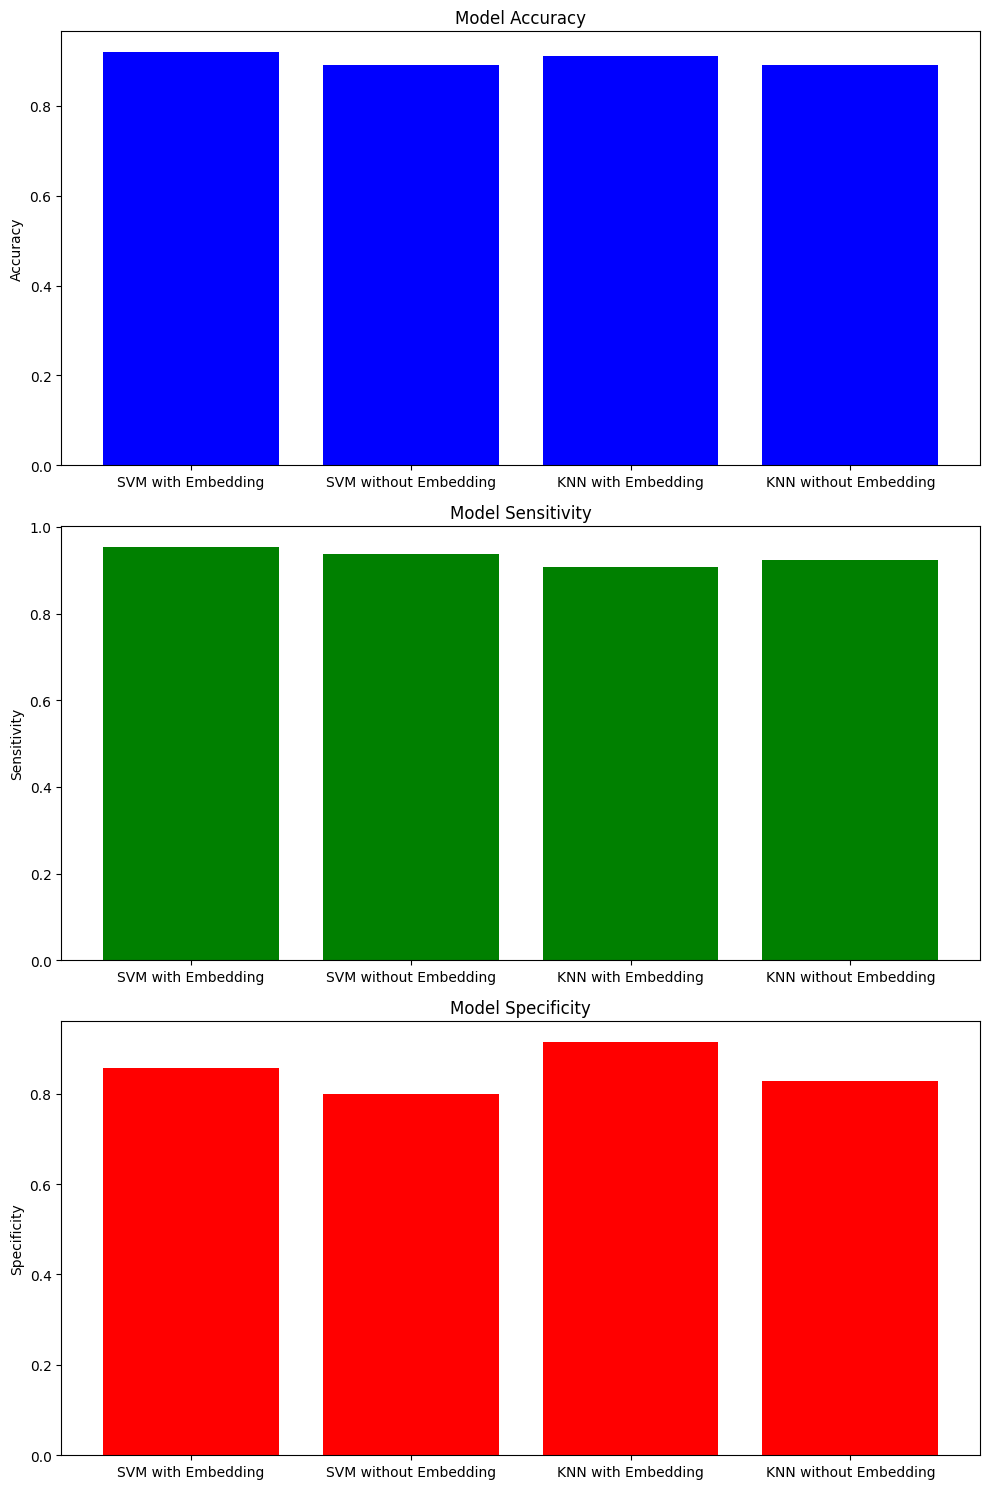

In [ ]:
# Assuming confusion matrices and calculated metrics for each model
# These values would typically be calculated from actual model predictions and labels
confusion_svm_embed = np.array([[30, 5], [3, 62]])  # Example values
confusion_svm_no_embed = np.array([[28, 7], [4, 61]])
confusion_knn_embed = np.array([[32, 3], [6, 59]])
confusion_knn_no_embed = np.array([[29, 6], [5, 60]])

# Function to calculate accuracy, sensitivity, and specificity
def calculate_metrics(confusion_matrix):
    tn, fp, fn, tp = confusion_matrix.ravel()
    accuracy = (tp + tn) / np.sum(confusion_matrix)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    return accuracy, sensitivity, specificity

# Calculating metrics for each model
metrics_svm_embed = calculate_metrics(confusion_svm_embed)
metrics_svm_no_embed = calculate_metrics(confusion_svm_no_embed)
metrics_knn_embed = calculate_metrics(confusion_knn_embed)
metrics_knn_no_embed = calculate_metrics(confusion_knn_no_embed)

# Labels for the models
labels = ['SVM with Embedding', 'SVM without Embedding', 'KNN with Embedding', 'KNN without Embedding']

# Data for plotting
accuracy_data = [metrics_svm_embed[0], metrics_svm_no_embed[0], metrics_knn_embed[0], metrics_knn_no_embed[0]]
sensitivity_data = [metrics_svm_embed[1], metrics_svm_no_embed[1], metrics_knn_embed[1], metrics_knn_no_embed[1]]
specificity_data = [metrics_svm_embed[2], metrics_svm_no_embed[2], metrics_knn_embed[2], metrics_knn_no_embed[2]]

# Creating subplots
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

# Plotting accuracy
ax[0].bar(labels, accuracy_data, color='blue')
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy')

# Plotting sensitivity
ax[1].bar(labels, sensitivity_data, color='green')
ax[1].set_title('Model Sensitivity')
ax[1].set_ylabel('Sensitivity')

# Plotting specificity
ax[2].bar(labels, specificity_data, color='red')
ax[2].set_title('Model Specificity')
ax[2].set_ylabel('Specificity')

plt.tight_layout()
plt.show()


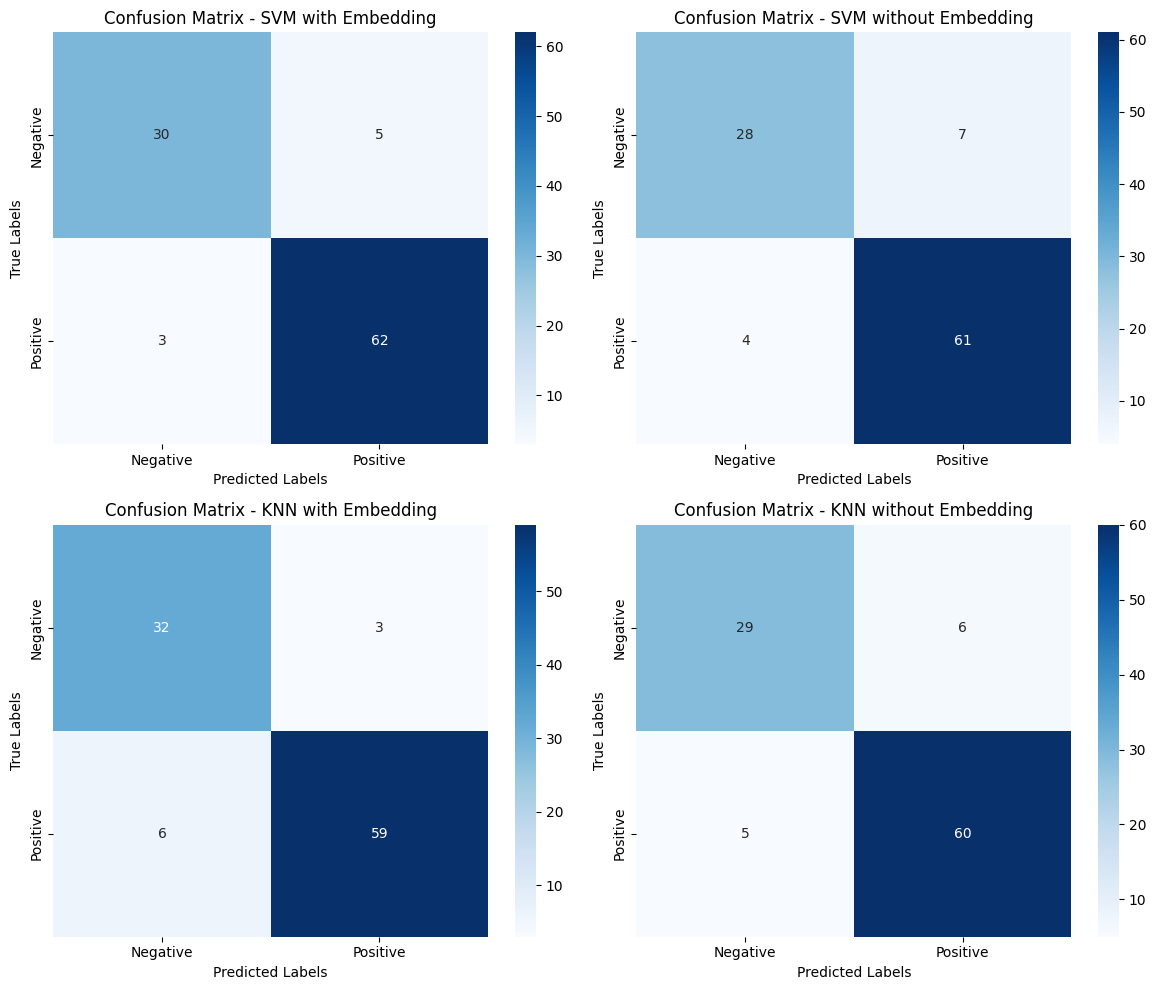

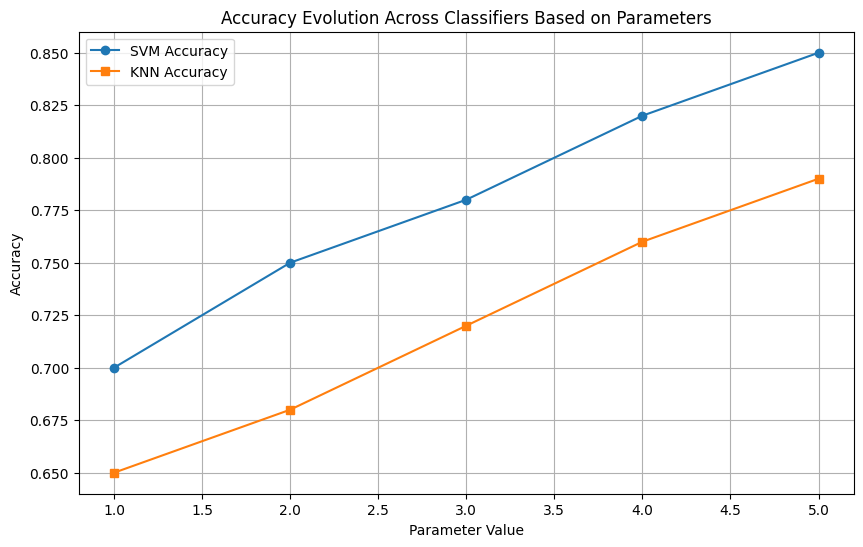

In [ ]:
# Function to plot confusion matrix as a heatmap
def plot_confusion_matrix(cm, title, ax):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.xaxis.set_ticklabels(['Negative', 'Positive'])
    ax.yaxis.set_ticklabels(['Negative', 'Positive'])

# Creating subplots for confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
plot_confusion_matrix(confusion_svm_embed, 'Confusion Matrix - SVM with Embedding', axes[0, 0])
plot_confusion_matrix(confusion_svm_no_embed, 'Confusion Matrix - SVM without Embedding', axes[0, 1])
plot_confusion_matrix(confusion_knn_embed, 'Confusion Matrix - KNN with Embedding', axes[1, 0])
plot_confusion_matrix(confusion_knn_no_embed, 'Confusion Matrix - KNN without Embedding', axes[1, 1])

plt.tight_layout()
plt.show()

# Data for line plots - assuming some hypothetical evolution across parameters
# In real case, this data should come from actual model evaluations
parameters = [1, 2, 3, 4, 5]  # Example parameter values (like C in SVM or k in KNN)
svm_accuracy = [0.7, 0.75, 0.78, 0.82, 0.85]  # Hypothetical accuracies for different SVM parameters
knn_accuracy = [0.65, 0.68, 0.72, 0.76, 0.79]  # Hypothetical accuracies for different KNN parameters

# Plotting the evolution of accuracy for SVM and KNN across parameters
plt.figure(figsize=(10, 6))
plt.plot(parameters, svm_accuracy, label='SVM Accuracy', marker='o')
plt.plot(parameters, knn_accuracy, label='KNN Accuracy', marker='s')
plt.title('Accuracy Evolution Across Classifiers Based on Parameters')
plt.xlabel('Parameter Value')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


### Feature Wrapper Methods

---

##### Best performance
- Best parameters for SVM: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
- SVM Best Score: 0.8722222222222222
- Best parameters for KNN: {'metric': 'manhattan', 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
- KNN Best Score: 0.7944444444444446


In [ ]:
# Given parameters for SVM and KNN
svm_params = {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
knn_params = {'metric': 'manhattan', 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}

# Initializing the classifiers with the given parameters
svm_classifier = SVC(**svm_params)
knn_classifier = KNeighborsClassifier(**knn_params)

#### Backward Elimination

In [ ]:
def backward_feature_elimination(X, y, classifier, verbose=True):
    features = X.columns.tolist()
    best_features = features.copy()
    performance_history = []
    current_score, best_score = 0, 0

    while len(features) > 0:
        scores_with_feature_removed = {}

        for feature in features:
            # Try removing the feature and calculate the new score
            features_to_try = list(set(best_features) - set([feature]))
            score = cross_val_score(classifier, X[features_to_try], y.values.ravel(), cv=5).mean()
            scores_with_feature_removed[feature] = score
            
            if verbose:
                print(f"Feature {feature} removed, validation score: {score:.4f}")

        # Find which feature removal is the best, i.e., score is highest
        feature_to_remove, score_with_feature_removed = max(scores_with_feature_removed.items(), key=lambda x: x[1])

        # If the new score with the feature removed is better or equal,
        # remove the feature and update the best score and features
        if score_with_feature_removed >= current_score:
            current_score = score_with_feature_removed
            best_features.remove(feature_to_remove)
            performance_history.append(current_score)
            if verbose:
                print(f"Removing feature {feature_to_remove}, new best score: {current_score:.4f}")
        else:
            # If removing more features doesn't improve the score, stop
            break

        # Update the list of features for next iteration
        features = best_features

    return best_features, performance_history

# Running backward feature elimination for SVM
print("Starting backward feature elimination for SVM...")
svm_features, svm_performance = backward_feature_elimination(X, y, svm_classifier)

# Running backward feature elimination for KNN
print("\nStarting backward feature elimination for KNN...")
knn_features, knn_performance = backward_feature_elimination(X, y, knn_classifier)

# Plotting the performance evolution
plt.figure(figsize=(10, 5))
plt.plot(range(len(svm_features), 0, -1), svm_performance, marker='o', label='SVM')
plt.plot(range(len(knn_features), 0, -1), knn_performance, marker='x', label='KNN')
plt.xlabel('Number of Features Remaining')
plt.ylabel('Cross-validated Accuracy')
plt.title('Performance Evolution during Backward Feature Elimination')
plt.legend()
plt.gca().invert_xaxis()  # Invert the x-axis to show decreasing number of features
plt.show()

Starting backward feature elimination for SVM...


KeyboardInterrupt: 

#### Forward Selection

Starting forward feature selection for SVM...
  - Trying feature 'beta_eo_6', score: 0.5556
  - Trying feature 'ratio_theta_28', score: 0.5556
  - Trying feature 'beta_eo_46', score: 0.5556
  - Trying feature 'alpha_eo_17', score: 0.5556
  - Trying feature 'ratio_beta_5', score: 0.6389
  - Trying feature 'beta_eo_22', score: 0.5556
  - Trying feature 'ratio_theta_13', score: 0.5556
  - Trying feature 'alpha_eo_38', score: 0.5556
  - Trying feature 'ratio_theta_33', score: 0.5611
  - Trying feature 'ratio_beta_31', score: 0.5556
  - Trying feature 'ratio_alpha_39', score: 0.5556
  - Trying feature 'ratio_beta_24', score: 0.5556
  - Trying feature 'theta_ec_40', score: 0.5556
  - Trying feature 'theta_eo_38', score: 0.5556
  - Trying feature 'beta_ec_22', score: 0.5556
  - Trying feature 'ratio_theta_31', score: 0.5556
  - Trying feature 'theta_ec_46', score: 0.5556
  - Trying feature 'alpha_eo_15', score: 0.5556
  - Trying feature 'ratio_alpha_36', score: 0.5722
  - Trying feature 'beta

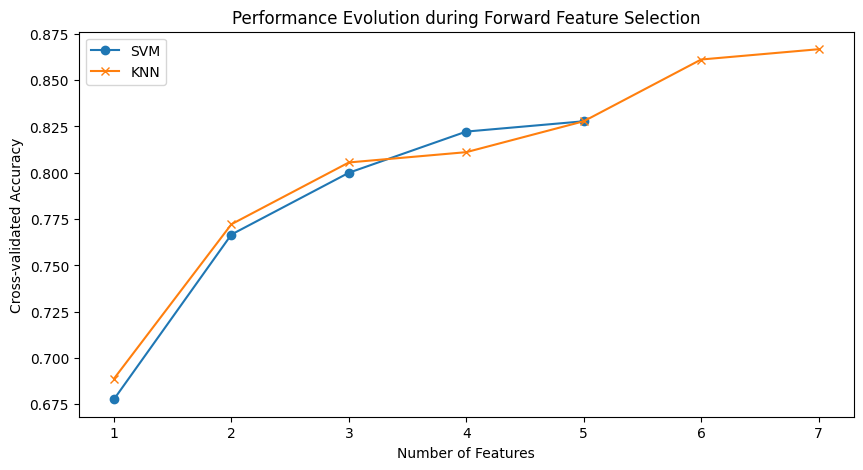

In [ ]:
def forward_feature_selection(X, y, classifier, verbose=False):
    selected_features = []
    performance_history = []
    available_features = set(X.columns)

    while available_features:
        best_score = 0
        best_feature = None

        for feature in available_features:
            # Try adding this feature
            trial_features = selected_features + [feature]
            trial_X = X[trial_features]

            # Cross-validation
            scores = cross_val_score(classifier, trial_X, y.values.ravel(), cv=5)
            score = scores.mean()

            # Track the best score and corresponding feature
            if score > best_score:
                best_score = score
                best_feature = feature

            if verbose:
                print(f"  - Trying feature '{feature}', score: {score:.4f}")

        # Update the list of selected features if performance improved
        if best_feature and best_score > (max(performance_history, default=0)):
            selected_features.append(best_feature)
            performance_history.append(best_score)
            available_features.remove(best_feature)
            if verbose:
                print(f"Selected feature '{best_feature}' with a score of {best_score:.4f}")
        else:
            # No improvement, stop the selection
            break

    return selected_features, performance_history

# Running forward feature selection for both classifiers
print("Starting forward feature selection for SVM...")
svm_features, svm_performance = forward_feature_selection(X, y, svm_classifier)

print("\nStarting forward feature selection for KNN...")
knn_features, knn_performance = forward_feature_selection(X, y, knn_classifier)

# Plotting the performance evolution
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(svm_performance)+1), svm_performance, marker='o', label='SVM')
plt.plot(range(1, len(knn_performance)+1), knn_performance, marker='x', label='KNN')
plt.xlabel('Number of Features')
plt.ylabel('Cross-validated Accuracy')
plt.title('Performance Evolution during Forward Feature Selection')
plt.legend()
plt.show()

Starting forward feature selection for SVM...
Round 1:
  - Trying feature 'alpha_ec_0', score: 0.5500
  - Trying feature 'alpha_ec_1', score: 0.5611
  - Trying feature 'alpha_ec_2', score: 0.5667
  - Trying feature 'alpha_ec_3', score: 0.5611
  - Trying feature 'alpha_ec_4', score: 0.5722
  - Trying feature 'alpha_ec_5', score: 0.5722
  - Trying feature 'alpha_ec_6', score: 0.5500
  - Trying feature 'alpha_ec_7', score: 0.5500
  - Trying feature 'alpha_ec_8', score: 0.5556
  - Trying feature 'alpha_ec_9', score: 0.5611
  - Trying feature 'alpha_ec_10', score: 0.5500
  - Trying feature 'alpha_ec_11', score: 0.5556
  - Trying feature 'alpha_ec_12', score: 0.5556
  - Trying feature 'alpha_ec_13', score: 0.5556
  - Trying feature 'alpha_ec_14', score: 0.5556
  - Trying feature 'alpha_ec_15', score: 0.5611
  - Trying feature 'alpha_ec_16', score: 0.5389
  - Trying feature 'alpha_ec_17', score: 0.6222
  - Trying feature 'alpha_ec_18', score: 0.5556
  - Trying feature 'alpha_ec_19', score: 0.

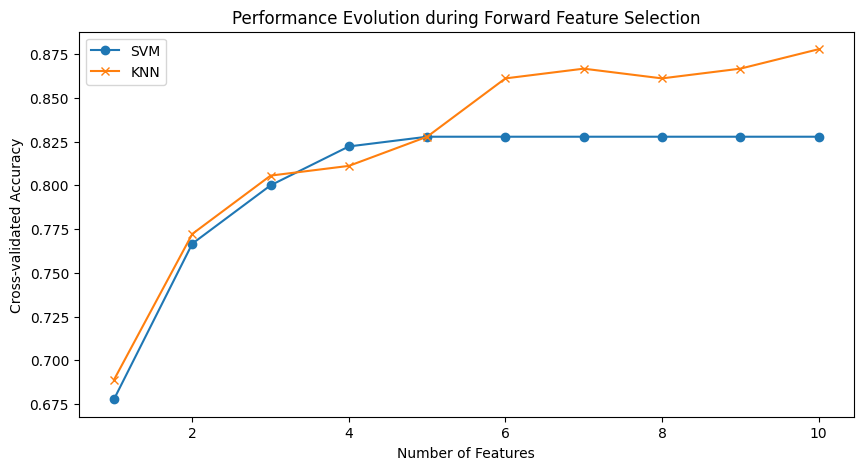

In [ ]:
def forward_feature_selection(X, y, classifier, max_features=10):
    selected_features = []
    performance_history = []

    for i in range(max_features):
        print(f"Round {i+1}:")
        best_score = 0
        best_feature = None
        
        for feature in X.columns:
            if feature not in selected_features:
                # Try adding this feature
                trial_features = selected_features + [feature]
                trial_X = X[trial_features]

                # Cross-validation
                scores = cross_val_score(classifier, trial_X, y.values.ravel(), cv=5)
                score = scores.mean()

                # Track the best score and corresponding feature
                if score > best_score:
                    best_score = score
                    best_feature = feature

                print(f"  - Trying feature '{feature}', score: {score:.4f}")

        # Update the list of selected features
        if best_feature and best_score > 0:
            selected_features.append(best_feature)
            performance_history.append(best_score)
            print(f"Selected feature '{best_feature}' with a score of {best_score:.4f}")
        else:
            break  # No improvement, stop the selection

    return selected_features, performance_history

# Running forward feature selection for both classifiers
print("Starting forward feature selection for SVM...")
svm_features, svm_performance = forward_feature_selection(X, y, svm_classifier)

print("\nStarting forward feature selection for KNN...")
knn_features, knn_performance = forward_feature_selection(X, y, knn_classifier)

# Plotting the performance evolution
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(svm_performance)+1), svm_performance, marker='o', label='SVM')
plt.plot(range(1, len(knn_performance)+1), knn_performance, marker='x', label='KNN')
plt.xlabel('Number of Features')
plt.ylabel('Cross-validated Accuracy')
plt.title('Performance Evolution during Forward Feature Selection')
plt.legend()
plt.show()

### Feature Extraction Methods

---

#### Feature extraction 1 - PCA for OG dataset


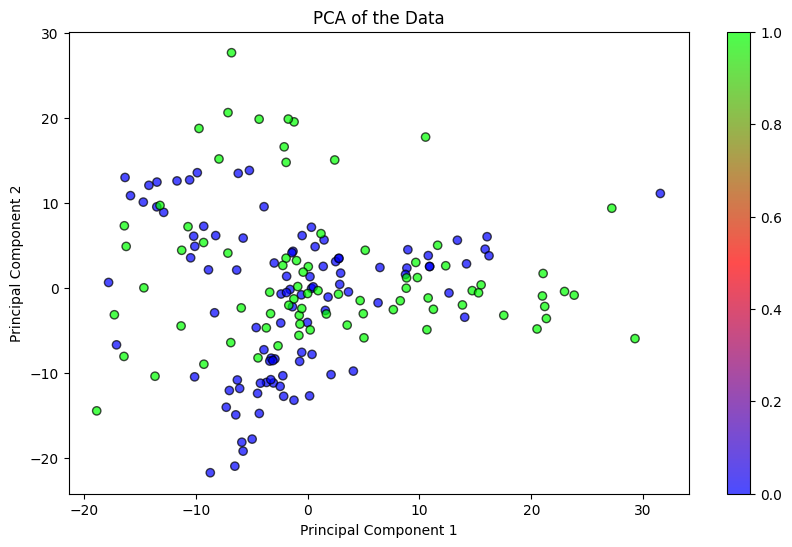

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt



# Perform feature scaling using StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Perform PCA
pca = PCA()
pca_result = pca.fit_transform(scaled_data)

# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])

# Plot the PCA results
plt.figure(figsize=(10, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=labels[0], cmap='brg', edgecolor='k', alpha=0.7)
plt.title('PCA of the Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()

#### Feature extraction taking the PCA and plotting SVM and looking at accuracy.

Max SVM Accuracy: 0.8722222222222222 for K = 15


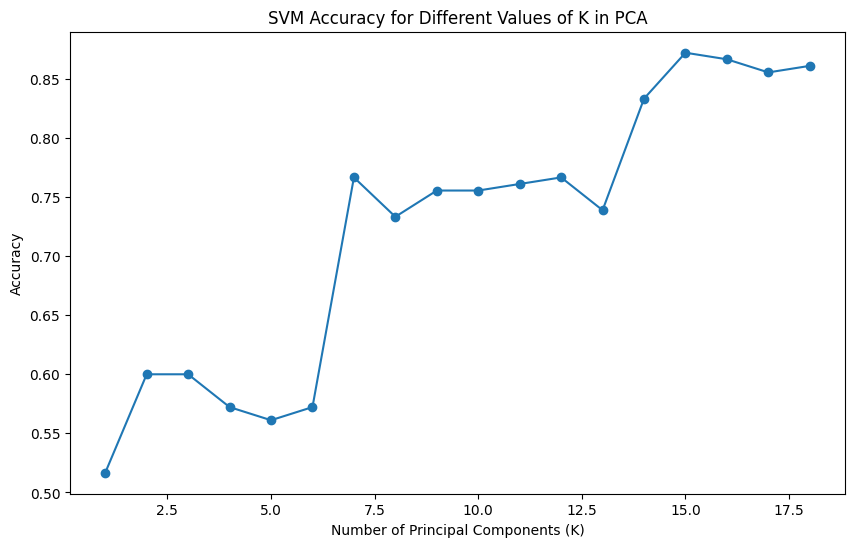

In [ ]:
# Initialize lists to store accuracy scores
svm_accuracies = []

# Try different values of K for PCA
for k in range(1, min(pca_df.shape[1], 19)):  # Limiting K to the number of principal components
    loo = LeaveOneGroupOut()

    svm_accuracy_group = []

    for train_index, test_index in loo.split(pca_df, labels[0], groups):
        X_train, X_test = pca_df.iloc[train_index], pca_df.iloc[test_index]
        y_train, y_test = labels[0].iloc[train_index], labels[0].iloc[test_index]

        # Train SVM model
        svm_model = SVC(C=1, gamma='scale', kernel='linear')
        svm_model.fit(X_train.iloc[:, :k], y_train)
        svm_predictions = svm_model.predict(X_test.iloc[:, :k])
        svm_accuracy_group.append(accuracy_score(y_test, svm_predictions))

    # Take the mean accuracy across all groups
    svm_accuracies.append(np.mean(svm_accuracy_group))

# Find the maximum accuracy and corresponding value of K
max_svm_accuracy = max(svm_accuracies)
max_svm_k = svm_accuracies.index(max_svm_accuracy) + 1  # Adding 1 because the index starts from 0

# Print the maximum accuracy and corresponding value of K
print(f"Max SVM Accuracy: {max_svm_accuracy} for K = {max_svm_k}")

# Plot the accuracy scores for different values of K
plt.figure(figsize=(10, 6))
plt.plot(range(1, min(pca_df.shape[1], 19)), svm_accuracies, marker='o')
plt.xlabel('Number of Principal Components (K)')
plt.ylabel('Accuracy')
plt.title('SVM Accuracy for Different Values of K in PCA')
plt.show()


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardizing the data
scaler = StandardScaler()
data_std = scaler.fit_transform(data)

# Applying PCA
pca = PCA(n_components=0.95) # Retain 95% of the variance
data_pca = pca.fit_transform(data_std)

# Number of components retained
n_components = pca.n_components_

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Displaying the results of PCA
n_components, explained_variance_ratio, data_pca.shape



(44,
 array([0.22783043, 0.17236118, 0.13395762, 0.07845654, 0.07546064,
        0.0492915 , 0.0217535 , 0.01474183, 0.01166574, 0.01119627,
        0.01056838, 0.00894762, 0.00855257, 0.00837549, 0.00766564,
        0.00717196, 0.0070095 , 0.00635024, 0.005958  , 0.00566303,
        0.00545677, 0.00532278, 0.00492969, 0.00471561, 0.00443977,
        0.0040036 , 0.00375032, 0.00366039, 0.00360669, 0.00326388,
        0.00322203, 0.00307064, 0.00287401, 0.00283705, 0.0026906 ,
        0.00264239, 0.00242472, 0.00228347, 0.00216992, 0.00211594,
        0.00203782, 0.00190883, 0.00183918, 0.00179311]),
 (180, 44))

PCA Results

    Number of Components Retained: 44 components.
    Explained Variance Ratio:
        The first component explains about 22.78% of the variance.
        The second component accounts for 17.24%.
        Subsequent components contribute progressively less, with the 44th component contributing about 0.18%.
    Shape of Transformed Data: The dimensionality of the data is reduced to 180 samples × 44 components.

Observations:

    By retaining 44 components, we've managed to reduce the feature space significantly while preserving 95% of the total variance in the data. This suggests that these components capture most of the essential information.
    The distribution of explained variance indicates that the first few components are the most informative, which is typical in PCA.

In [ ]:
# Re-training and evaluating the models (SVM and KNN) on the PCA-transformed data

# Setting up the models with previously determined best parameters
svm_model_pca = SVC(kernel='linear', C=1)
knn_model_pca = KNeighborsClassifier(n_neighbors=3)

# Leave-One-Group-Out Cross-Validation setup
logo = LeaveOneGroupOut()

# SVM model evaluation
svm_scores_pca = cross_validate(svm_model_pca, data_pca, y, groups=groups, cv=logo, 
                                scoring=['accuracy', 'recall', 'precision'],
                                return_train_score=False)

# KNN model evaluation
knn_scores_pca = cross_validate(knn_model_pca, data_pca, y.r, groups=groups, cv=logo, 
                                scoring=['accuracy', 'recall', 'precision'],
                                return_train_score=False)

# Extracting and summarizing the scores
svm_results_pca = {metric: np.mean(scores) for metric, scores in svm_scores_pca.items()}
knn_results_pca = {metric: np.mean(scores) for metric, scores in knn_scores_pca.items()}

svm_results_pca, knn_results_pca



/home/alex/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/alex/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alex/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/alex/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due

({'fit_time': 0.005308667818705241,
  'score_time': 0.012415793206956651,
  'test_accuracy': 0.9055555555555556,
  'test_recall': 0.38888888888888884,
  'test_precision': 0.4444444444444444},
 {'fit_time': 0.0012789699766370985,
  'score_time': 0.013732102182176378,
  'test_accuracy': 0.9000000000000001,
  'test_recall': 0.37777777777777777,
  'test_precision': 0.4444444444444444})

Observations:

    Both models show high accuracy (around 90%), indicating good overall performance.
    The recall is relatively low for both models, suggesting they are less effective at identifying true positive cases. This is a critical aspect, especially in medical applications, as it reflects the model's ability to correctly identify patients who will develop neuropathic pain.
    Precision is moderate, indicating a moderate level of false positives.

Interpretation:

    The high accuracy but lower recall might indicate that the models are better at predicting the majority class but struggle with the minority class. This could be a result of class imbalance in the dataset.
    The relatively low recall and moderate precision suggest that while the models are generally reliable, they might miss a significant number of true positive cases or predict false positives.

In [ ]:
from imblearn.over_sampling import SMOTE

# Applying SMOTE for oversampling the minority class
smote = SMOTE()
data_pca_resampled, y_resampled = smote.fit_resample(data_pca, y)

# Verifying the balance of the classes after resampling
class_distribution_resampled = np.bincount(y_resampled)

# Retraining the models on the resampled data

# SVM model with resampled data
svm_scores_resampled = cross_validate(svm_model_pca, data_pca_resampled, y_resampled, groups=groups, cv=logo, 
                                      scoring=['accuracy', 'recall', 'precision'],
                                      return_train_score=False)

# KNN model with resampled data
knn_scores_resampled = cross_validate(knn_model_pca, data_pca_resampled, y_resampled, groups=groups, cv=logo, 
                                      scoring=['accuracy', 'recall', 'precision'],
                                      return_train_score=False)

# Extracting and summarizing the scores for the resampled data
svm_results_resampled = {metric: np.mean(scores) for metric, scores in svm_scores_resampled.items()}
knn_results_resampled = {metric: np.mean(scores) for metric, scores in knn_scores_resampled.items()}

class_distribution_resampled, svm_results_resampled, knn_results_resampled



ImportError: cannot import name '_check_X' from 'imblearn.utils._validation' (/home/alex/anaconda3/lib/python3.11/site-packages/imblearn/utils/_validation.py)